# Download libraries

In [ ]:
!pip3 install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.0 MB/s eta 0:00:00


# Import required libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import shap
import textwrap

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def evaluate_model(model, X_test, y_test, labels=None, sample_weights=None):
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    print(classification_report(
        y_test, y_pred,
        target_names=labels, sample_weight=sample_weights
    ))
    auc = roc_auc_score(
        y_test, y_proba,
        multi_class="ovr", average="weighted",
        sample_weight=sample_weights
    )
    print(f"Weighted AUROC: {auc:.4f}")

# Load preprocessed data

In [ ]:
train_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/training_dataset.csv' #"/home/andres/Documents/CS7641_ML/project/random_forest/data/training_dataset.csv"
test_path = '/content/drive/MyDrive/Colab_Notebooks/CS7641_ML/data/test_dataset.csv' #"/home/andres/Documents/CS7641_ML/project/random_forest/data/test_dataset.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['pam50_+_claudin-low_subtype'].value_counts()

,count
pam50_+_claudin-low_subtype,
LumA,552
LumB,369
Her2,169
Basal,162
claudin-low,160
Normal,109
NC,2


In [ ]:
train_df = train_df[train_df['pam50_+_claudin-low_subtype'] != 'NC']
test_df = test_df[test_df['pam50_+_claudin-low_subtype'] != 'NC']

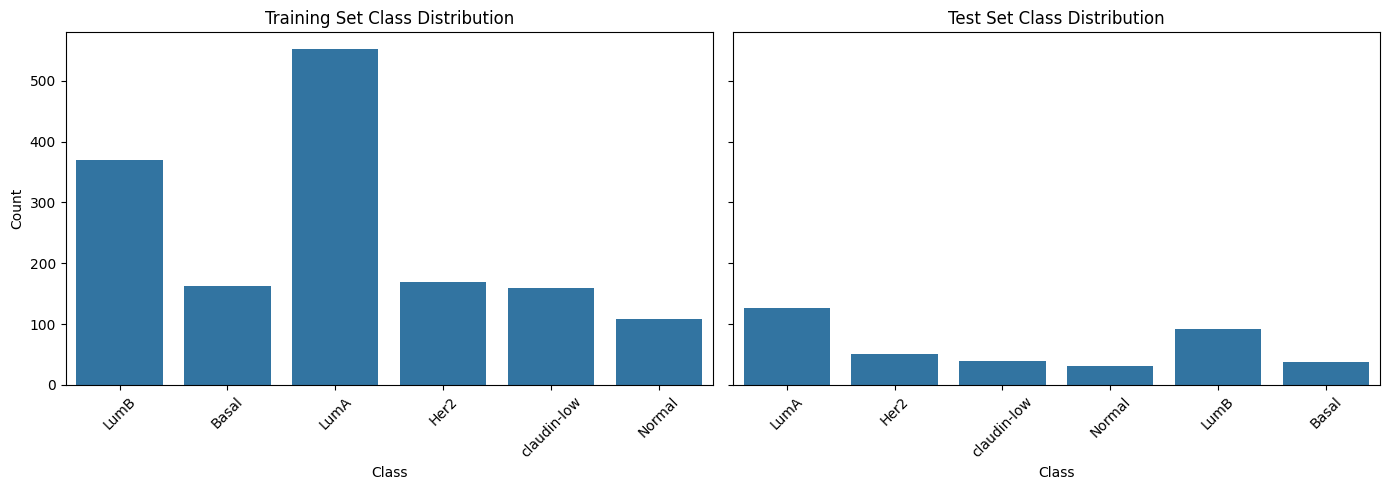

In [ ]:
# Plot side-by-side class distributions
target_col = 'pam50_+_claudin-low_subtype'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.countplot(x=train_df[target_col], ax=axes[0])
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x=test_df[target_col], ax=axes[1])
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Separate features and target

In [ ]:
X_train = train_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_train = train_df['pam50_+_claudin-low_subtype']

X_test = test_df.drop(columns=['pam50_+_claudin-low_subtype'])
y_test = test_df['pam50_+_claudin-low_subtype']

In [ ]:
# Compute balanced sample weights
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_test = compute_sample_weight(class_weight='balanced', y=y_test)

# Encode labels

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Perform RF

In [ ]:
rf = RandomForestClassifier(
    class_weight="balanced",
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1,
)

param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc_ovr',
    random_state=42,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_
print("Best params:", rand_search.best_params_)
print("Best CV AUC:", rand_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}
Best CV AUC: 0.9524838927277784


In [ ]:
cv_results_df.columns.tolist()

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_max_features',
 'param_max_depth',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [ ]:
# Build table with results
cv_results_df = pd.DataFrame(rand_search.cv_results_)
cv_results_df[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head()

,params,mean_train_score,mean_test_score
49,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.999958,0.952484
23,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.999958,0.952477
16,"{'n_estimators': 500, 'min_samples_split': 10,...",0.999194,0.952094
14,"{'n_estimators': 1000, 'min_samples_split': 2,...",1.000000,0.951951
27,"{'n_estimators': 1000, 'min_samples_split': 5,...",0.998745,0.951700


# Decode/Predictions

In [ ]:
# Predict
y_pred = best_rf.predict(X_test)

# Decode predictions and test back to original labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Confusion matrix

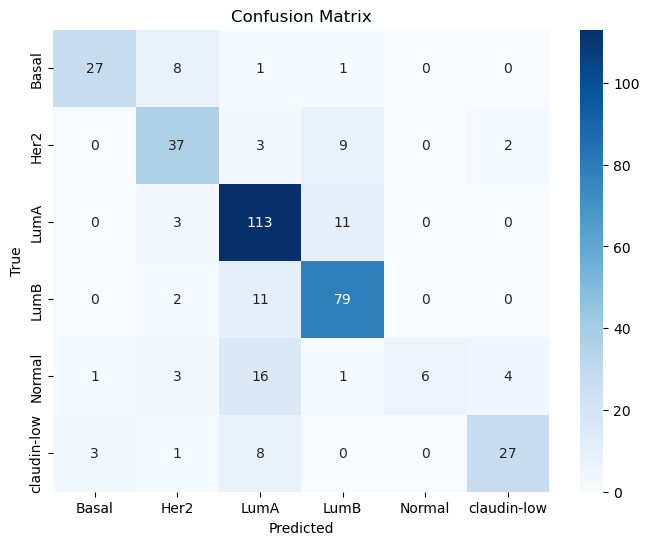

In [ ]:
labels = le.classes_
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report

In [ ]:
# now safe to call
evaluate_model(best_rf, X_test, y_test, le.classes_)


              precision    recall  f1-score   support

       Basal       0.87      0.73      0.79        37
        Her2       0.69      0.73      0.70        51
        LumA       0.74      0.89      0.81       127
        LumB       0.78      0.86      0.82        92
      Normal       1.00      0.19      0.32        31
 claudin-low       0.82      0.69      0.75        39

    accuracy                           0.77       377
   macro avg       0.82      0.68      0.70       377
weighted avg       0.79      0.77      0.75       377

Weighted AUROC: 0.9474


In [ ]:
print(le.classes_)

['Basal' 'Her2' 'LumA' 'LumB' 'Normal' 'claudin-low']


# AUROC Plot

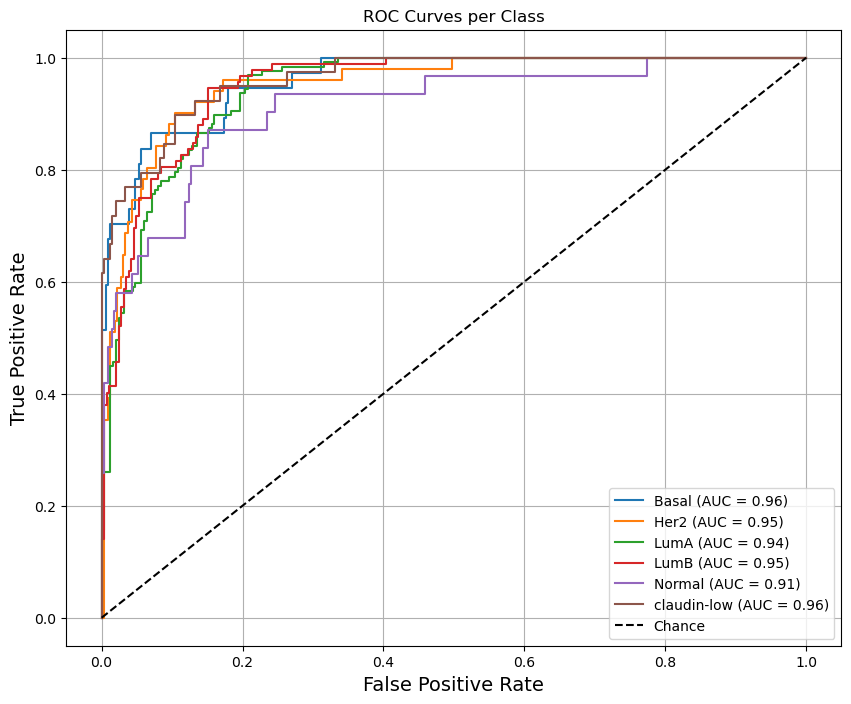

In [ ]:
y_score = best_rf.predict_proba(X_test)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curves per Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# SHAP analysis for RF

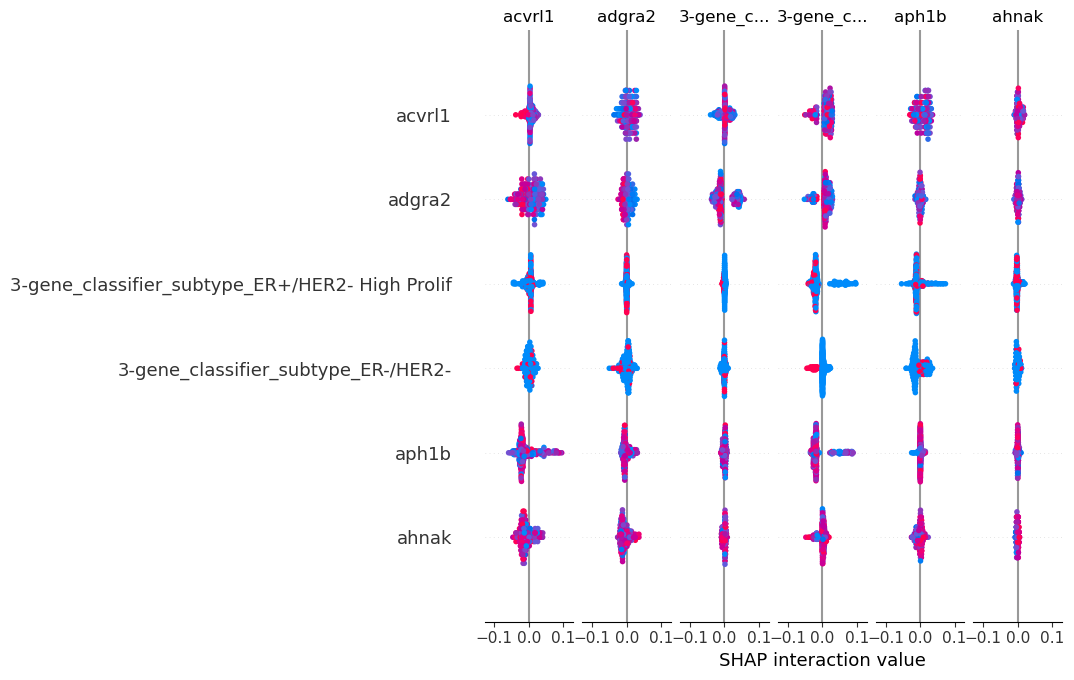

(300, 50, 6)
(300, 50)


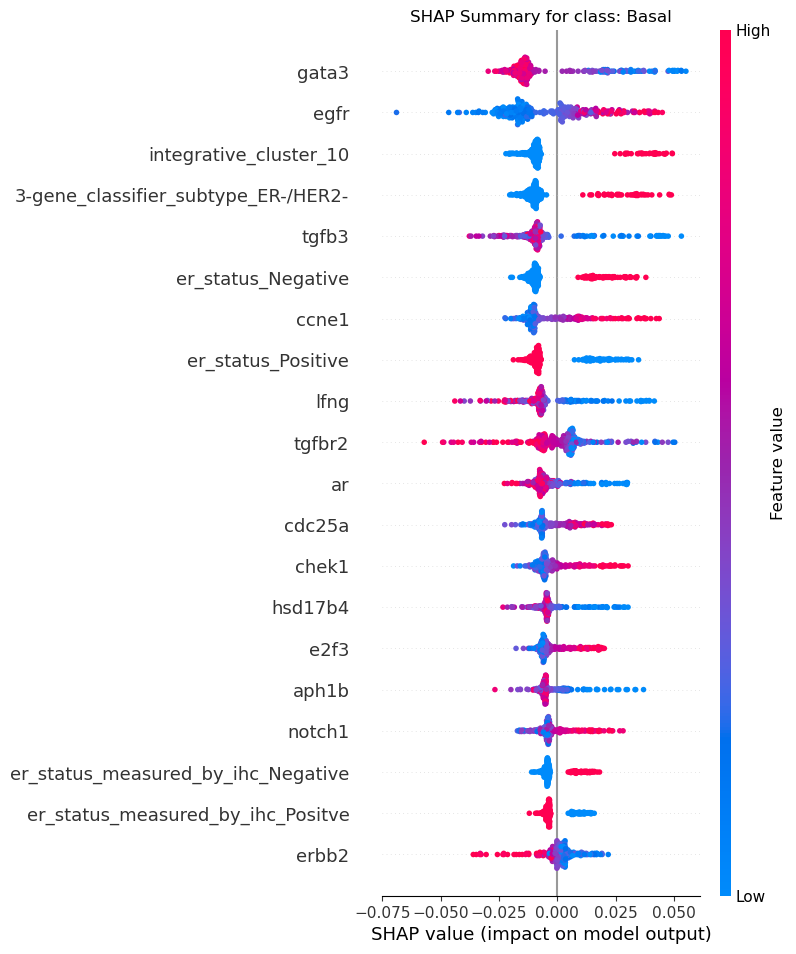

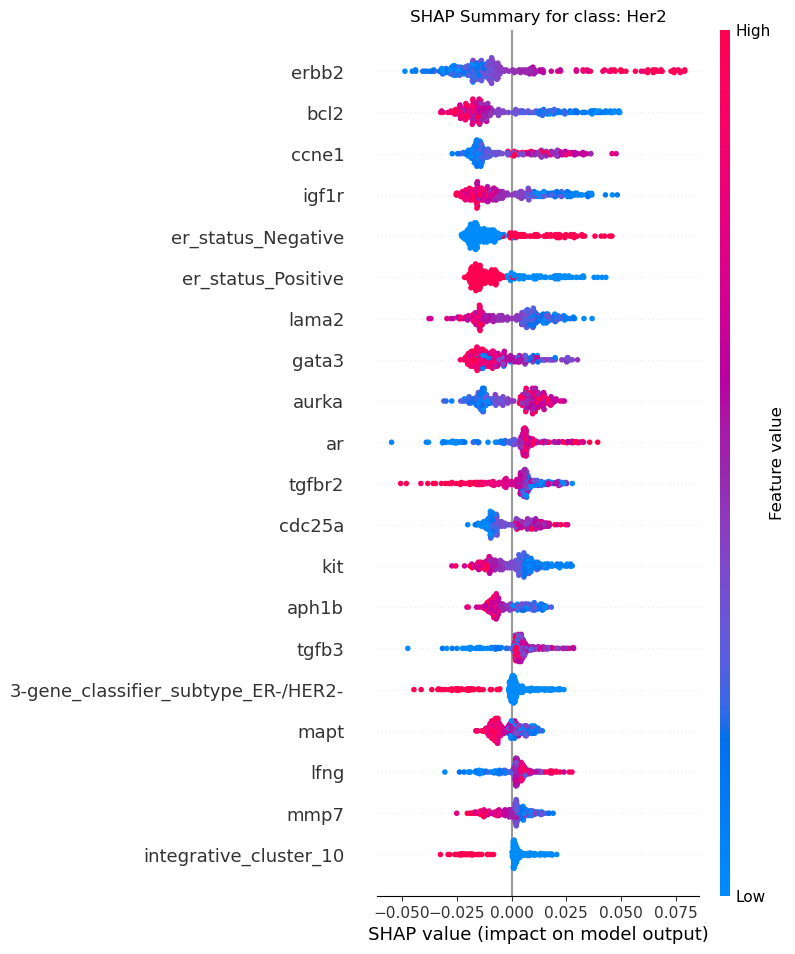

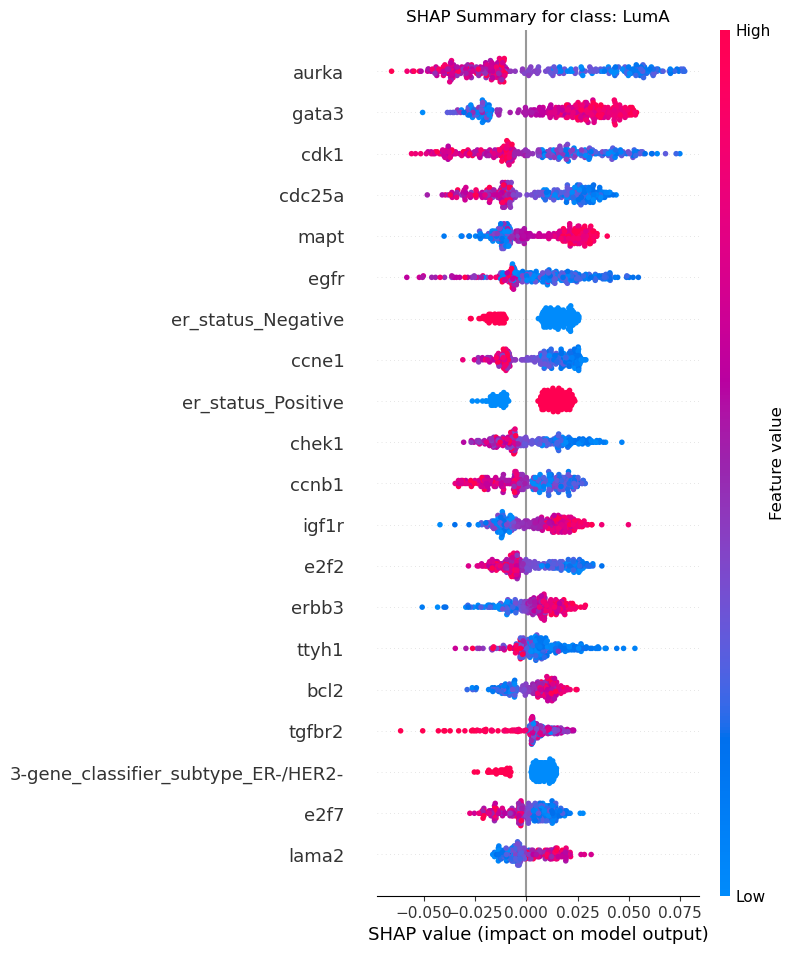

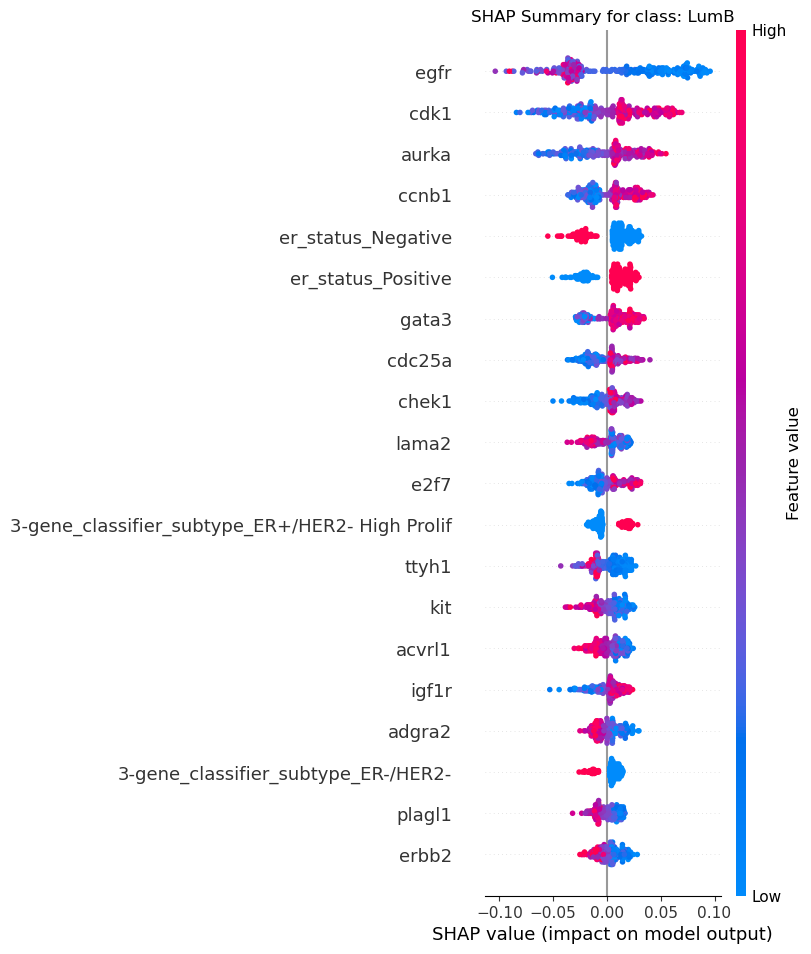

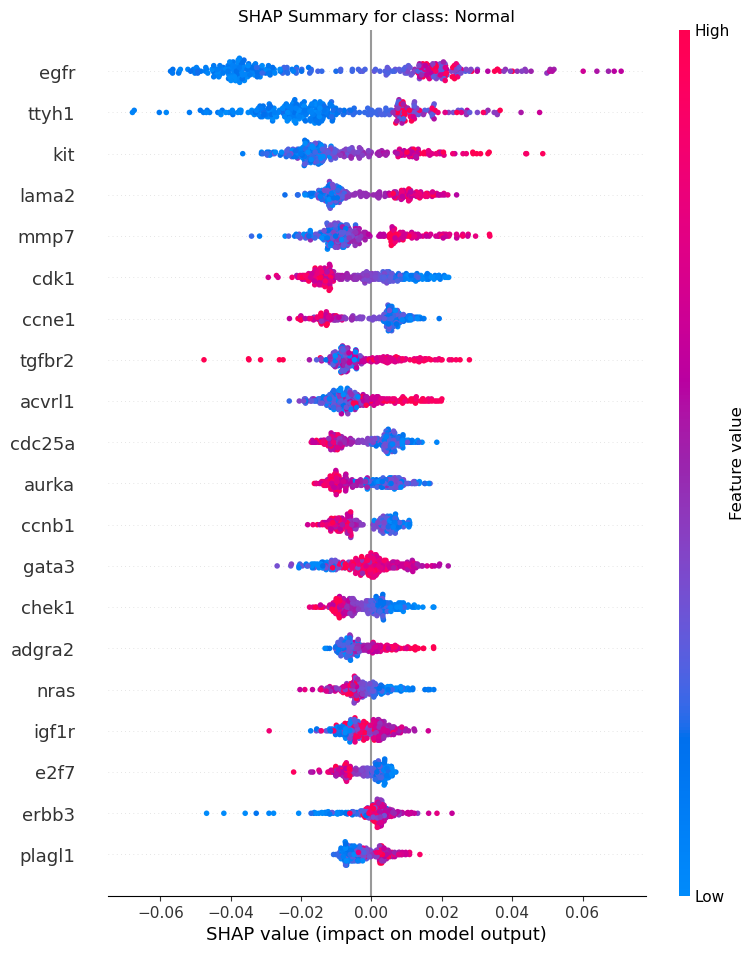

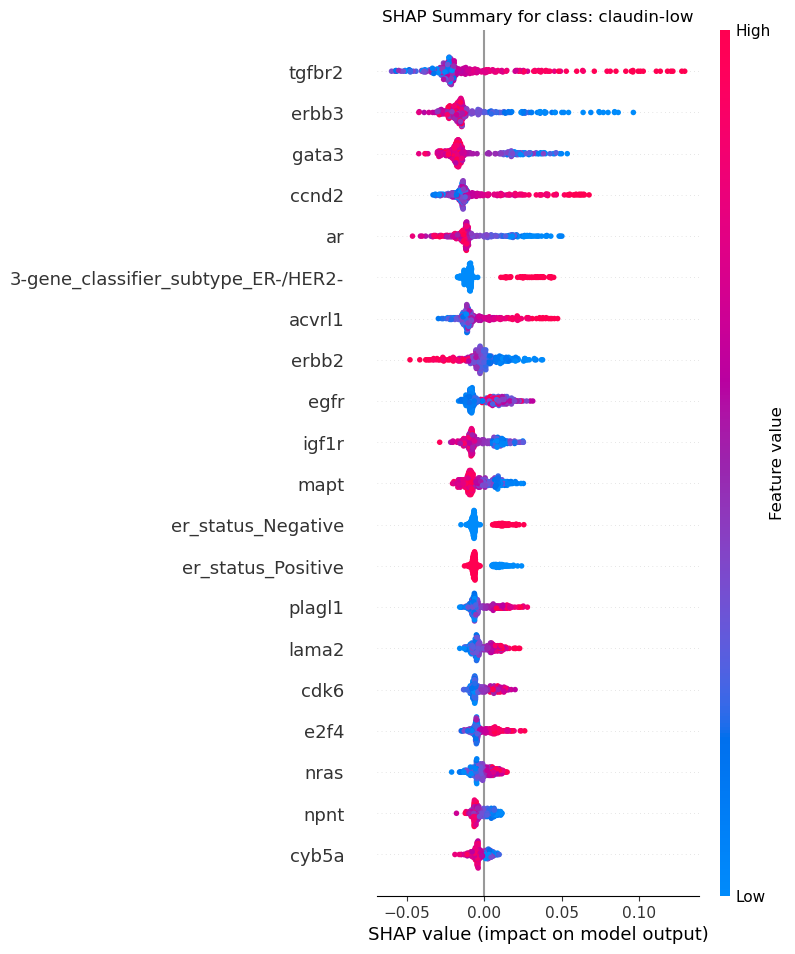

In [ ]:
X_test_sample = X_test.sample(n=300, random_state=42)

explainer   = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_sample) #explainer(X_test_sample,        # Explanation object
                       #interactions=True) #explainer.shap_values(X_test_sample)   # list of arrays

#shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns, class_names=le.classes_)
shap.summary_plot(shap_values, X_test_sample,
                  feature_names=X_test_sample.columns,
                  class_names=le.classes_)
print(shap_values.shape)
print(X_test_sample.shape)

for k, class_name in enumerate(le.classes_):
    #print(f"SHAP Summary for class: {class_name}")
    shap.summary_plot(shap_values[...,k], X_test_sample,
                      feature_names=X_test_sample.columns,
                      show=False)
    plt.title(f"SHAP Summary for class: {class_name}")
    plt.show()



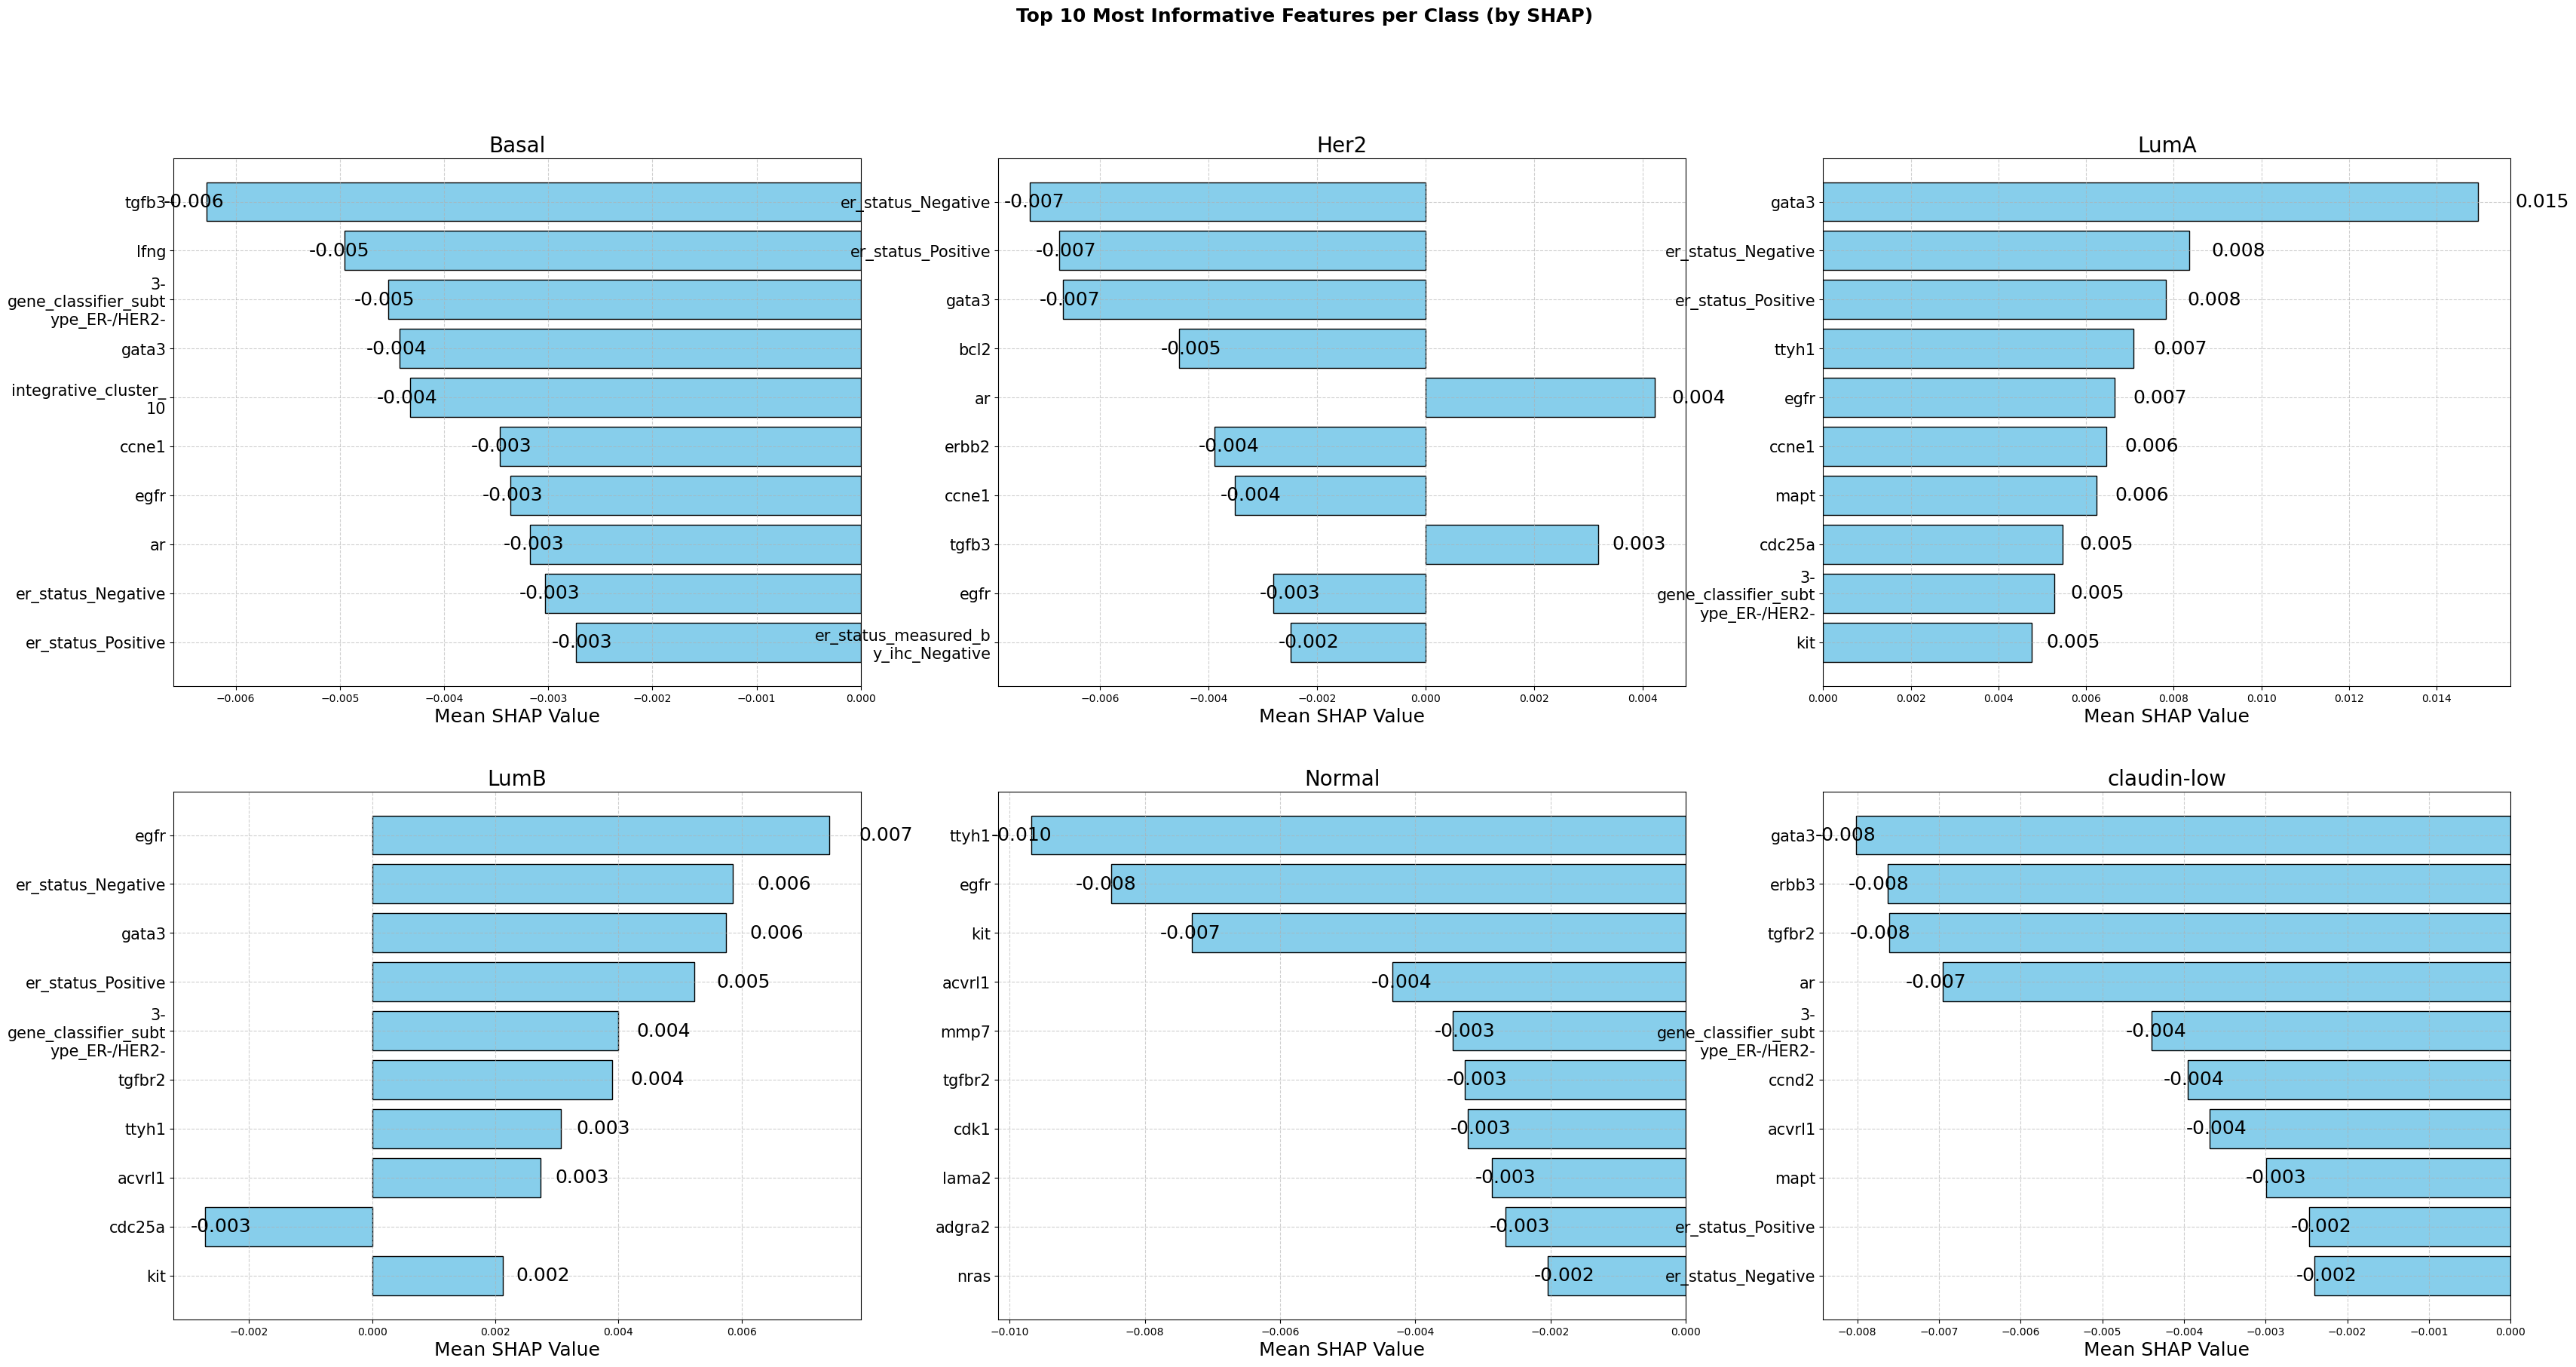

In [ ]:
# Assume shap_values has shape (n_samples, n_features, n_classes)
n_samples, n_features, n_classes = shap_values.shape

# Use column names if X_test_sample is a DataFrame, else make generic names
feature_names = (
    X_test_sample.columns
    if hasattr(X_test_sample, 'columns')
    else [f"feature_{i}" for i in range(n_features)]
)

# Function to wrap long feature names into multiple lines
def wrap_labels(labels, width=15):
    wrapped = []
    for label in labels:
        wrapped_label = "\n".join(textwrap.wrap(label, width=width))
        wrapped.append(wrapped_label)
    return wrapped

# Class labels from LabelEncoder
class_labels = le.classes_

# Create subplots
n_rows, n_cols = 2, 3  # for 6 classes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(40, 20))
axes = np.array(axes).ravel()

for class_idx in range(n_classes):
    ax = axes[class_idx]

    # Extract SHAP values for class `class_idx`
    class_shap = shap_values[:, :, class_idx]

    # Compute mean SHAP value and mean absolute SHAP value
    shap_avg = np.mean(class_shap, axis=0)
    shap_abs_avg = np.abs(shap_avg)

    # Get top 10 feature indices by abs(mean shap)
    sorted_idx = np.argsort(shap_abs_avg)[-10:]
    top_features = [feature_names[i] for i in sorted_idx]
    top_values = shap_avg[sorted_idx]

    # Wrap long feature names for better display
    top_features_wrapped = wrap_labels(top_features, width=20)

    # Plot
    bars = ax.barh(top_features_wrapped, top_values, color='skyblue', edgecolor='black')
    ax.set_title(f"{class_labels[class_idx]}", fontsize=20)
    ax.set_xlabel("Mean SHAP Value", fontsize=18)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Annotate bars
    for bar in bars:
        width = bar.get_width()
        offset = 0.05 * abs(width) + 1e-4  # dynamic spacing
        ax.text(
            width + np.sign(width) * offset,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}", va='center', fontsize=18
        )

    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=15)

# Hide unused subplots if any
for j in range(n_classes, n_rows * n_cols):
    fig.delaxes(axes[j])

# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Top 10 Most Informative Features per Class (by SHAP)", fontsize=18, weight='bold')
plt.show()


In [ ]:
# Compute mean SHAP value per feature per class:
mean_shap_per_class = np.mean(shap_values, axis=0)  # averages over samples

# Create DataFrame
mean_shap_df = pd.DataFrame(
    mean_shap_per_class,
    index=feature_names,
    columns=le.classes_
)

mean_shap_df

,Basal,Her2,LumA,LumB,Normal,claudin-low
3-gene_classifier_subtype_ER+/HER2- High Prolif,-0.000166,-0.000652,0.000937,0.000050,-0.000128,-0.000042
3-gene_classifier_subtype_ER-/HER2-,-0.004533,-0.000365,0.005274,0.003996,0.000020,-0.004392
acvrl1,0.000659,0.000338,0.004296,0.002731,-0.004338,-0.003686
adgra2,-0.000082,0.000508,0.002773,0.000509,-0.002669,-0.001039
ahnak,-0.000762,-0.000291,0.001684,0.000305,-0.001068,0.000132
aph1b,-0.002642,-0.001592,0.003525,0.000202,-0.000702,0.001209
ar,-0.003173,0.004209,0.004240,0.001641,0.000041,-0.006958
aurka,-0.000487,0.000133,0.003672,-0.001182,-0.002013,-0.000124
bcl2,-0.000285,-0.004550,0.003468,0.001164,-0.001050,0.001253
bmpr1b,-0.000191,-0.000419,0.001764,0.000308,-0.001123,-0.000339


Classes (breast cancer subtypes):
['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin-low']

Aggressive subtypes (from literature): Basal, claudin-low

Top 3 features for subtype 'Basal':
tgfb3                                  0.006283
lfng                                   0.004952
3-gene_classifier_subtype_ER-/HER2-    0.004533
Name: Basal, dtype: float64

Top 3 features for subtype 'Her2':
er_status_Negative    0.007299
er_status_Positive    0.006746
gata3                 0.006684
Name: Her2, dtype: float64

Top 3 features for subtype 'LumA':
gata3                 0.014936
er_status_Negative    0.008349
er_status_Positive    0.007815
Name: LumA, dtype: float64

Top 3 features for subtype 'LumB':
egfr                  0.007429
er_status_Negative    0.005861
gata3                 0.005742
Name: LumB, dtype: float64

Top 3 features for subtype 'Normal':
ttyh1    0.009685
egfr     0.008500
kit      0.007310
Name: Normal, dtype: float64

Top 3 features for subtype 'claudin-low':
gata3  

,Basal,Her2,LumA,LumB,Normal,claudin-low
Top 1,tgfb3,er_status_Negative,gata3,egfr,ttyh1,gata3
Top 2,lfng,er_status_Positive,er_status_Negative,er_status_Negative,egfr,erbb3
Top 3,3-gene_classifier_subtype_ER-/HER2-,gata3,er_status_Positive,gata3,kit,tgfbr2


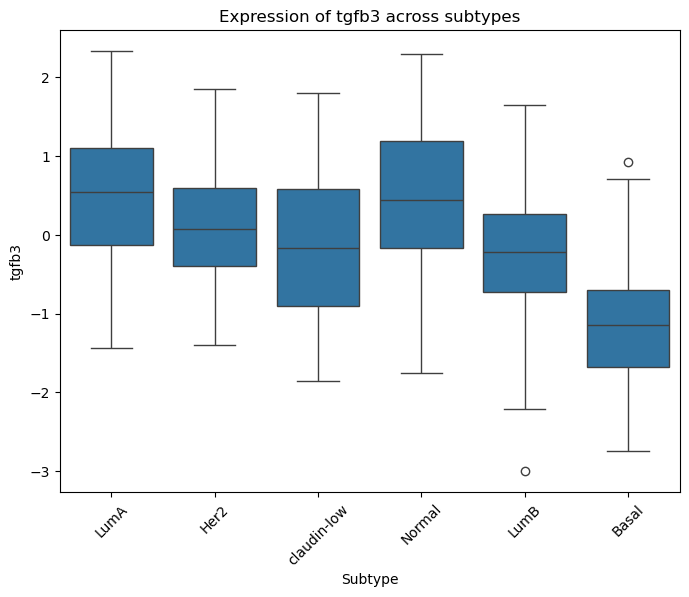

In [ ]:
print("Classes (breast cancer subtypes):")
print(mean_shap_df.columns.tolist())
print("\nAggressive subtypes (from literature): Basal, claudin-low\n")

top_features_by_class = {}

for class_name in mean_shap_df.columns:
    # Sort by absolute mean SHAP values descending, take top 3 features
    top_feats = mean_shap_df[class_name].abs().sort_values(ascending=False).head(3)
    top_features_by_class[class_name] = top_feats.index.tolist()
    print(f"Top 3 features for subtype '{class_name}':")
    print(top_feats)
    print()

print("\nTop feature SHAP values across all classes:")
for class_name in mean_shap_df.columns:
    top_feature = top_features_by_class[class_name][0]
    print(f"\nMean SHAP values of feature '{top_feature}' across all subtypes:")
    print(mean_shap_df.loc[top_feature])
    print()

# Create a summary table of top features per class
markers_table = pd.DataFrame.from_dict(top_features_by_class, orient='index').T
markers_table.index = ['Top 1', 'Top 2', 'Top 3']
print("Summary: Top marker features for each subtype:")
display(markers_table)

# Optional boxplot of expression for top gene in 'Basal' subtype
try:
    gene = top_features_by_class['Basal'][0]  # change 'Basal' if needed
    plot_df = X_test.copy()
    plot_df['Subtype'] = le.inverse_transform(y_test)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Subtype', y=gene, data=plot_df)
    plt.title(f"Expression of {gene} across subtypes")
    plt.xticks(rotation=45)
    plt.show()
except Exception as e:
    print(f"Optional plot skipped (reason: {e})")


Top marker features per class (class names):
Basal: ['tgfb3', 'lfng', '3-gene_classifier_subtype_ER-/HER2-', 'gata3', 'integrative_cluster_10', 'ccne1']
Her2: ['er_status_Negative', 'er_status_Positive', 'gata3', 'bcl2', 'ar', 'erbb2']
LumA: ['gata3', 'er_status_Negative', 'er_status_Positive', 'ttyh1', 'egfr', 'ccne1']
LumB: ['egfr', 'er_status_Negative', 'gata3', 'er_status_Positive', '3-gene_classifier_subtype_ER-/HER2-', 'tgfbr2']
Normal: ['ttyh1', 'egfr', 'kit', 'acvrl1', 'mmp7', 'tgfbr2']
claudin-low: ['gata3', 'erbb3', 'tgfbr2', 'ar', '3-gene_classifier_subtype_ER-/HER2-', 'ccnd2']

Class mapping (int label → class name): {0: 'Basal', 1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal', 5: 'claudin-low'}

Class name for Basal-like: Basal, Claudin-low: claudin-low

Top Basal-like markers (Basal): ['tgfb3', 'lfng', '3-gene_classifier_subtype_ER-/HER2-', 'gata3', 'integrative_cluster_10', 'ccne1']
Top Claudin-low markers (claudin-low): ['gata3', 'erbb3', 'tgfbr2', 'ar', '3-gene_classifier

,tgfb3,lfng,3-gene_classifier_subtype_ER-/HER2-,gata3,integrative_cluster_10,ccne1
Basal,-0.006283,-0.004952,-0.004533,-0.004427,-0.004327,-0.003467
Her2,0.003170,0.001952,-0.000365,-0.006684,0.000940,-0.003516
LumA,0.002096,0.001825,0.005274,0.014936,0.002743,0.006466
LumB,0.000374,0.000534,0.003996,0.005742,0.000819,-0.000231
Normal,-0.000036,-0.000829,0.000020,-0.001549,0.001530,0.000279
claudin-low,0.000679,0.001470,-0.004392,-0.008018,-0.001705,0.000469



Claudin-low marker feature SHAP values across all classes:


,gata3,erbb3,tgfbr2,ar,3-gene_classifier_subtype_ER-/HER2-,ccnd2
Basal,-0.004427,0.001036,0.000572,-0.003173,-0.004533,0.000335
Her2,-0.006684,0.001570,0.002211,0.004209,-0.000365,0.000798
LumA,0.014936,0.003950,0.004199,0.004240,0.005274,0.003099
LumB,0.005742,0.001086,0.003897,0.001641,0.003996,0.001056
Normal,-0.001549,-0.000012,-0.003272,0.000041,0.000020,-0.001332
claudin-low,-0.008018,-0.007630,-0.007608,-0.006958,-0.004392,-0.003955



Feature expression patterns for Basal markers:


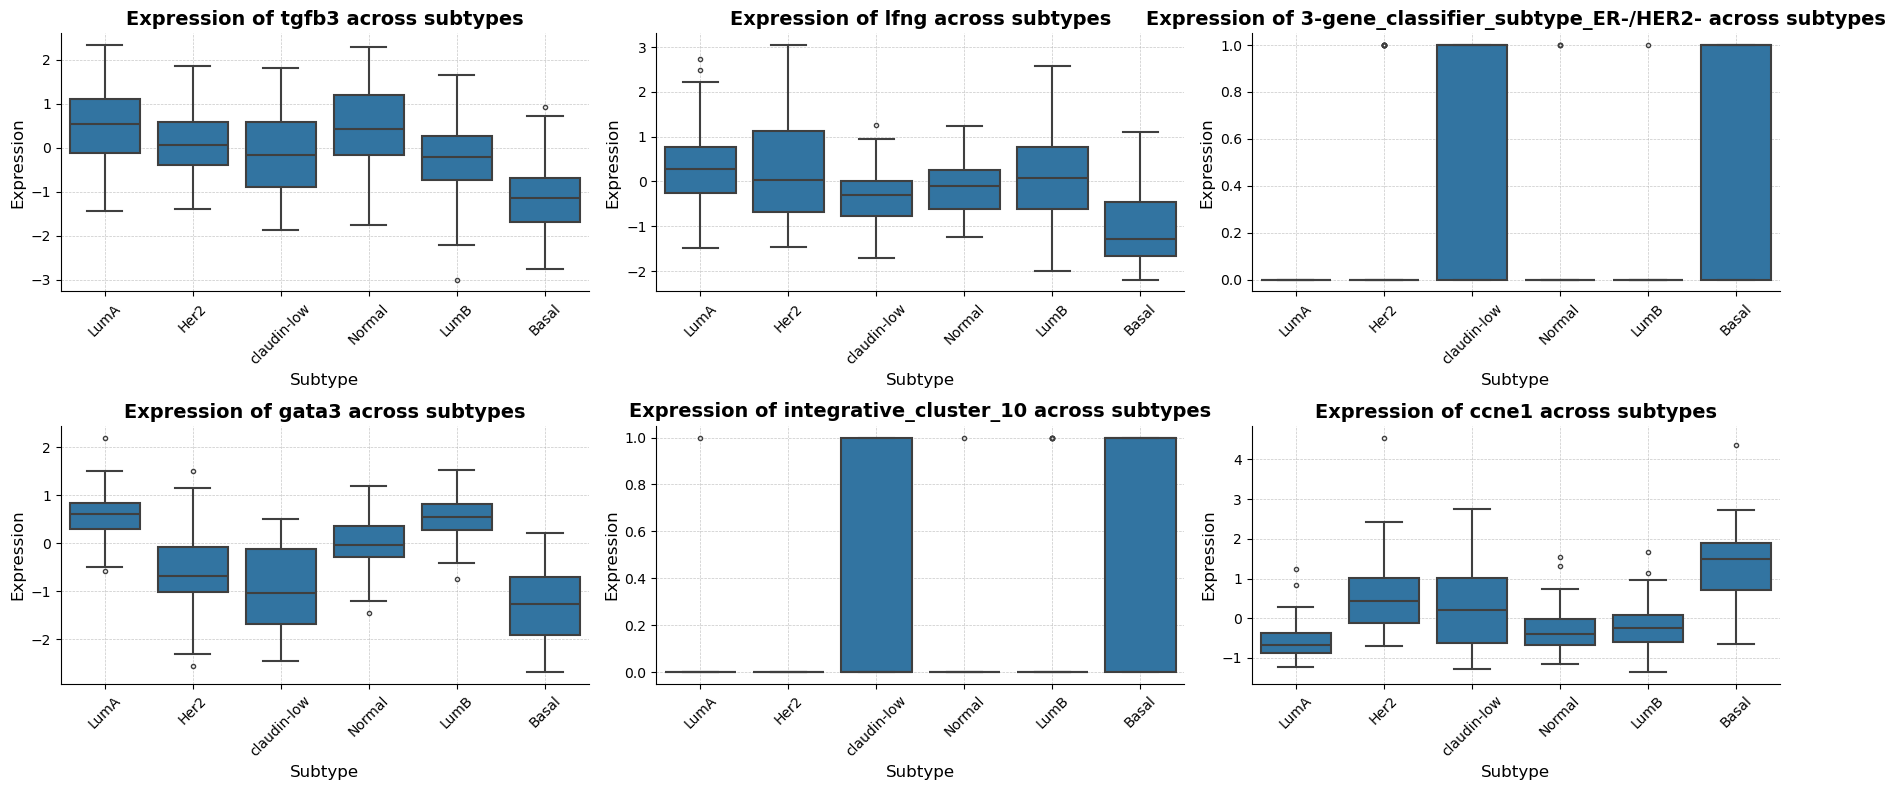


Feature expression patterns for claudin-low markers:


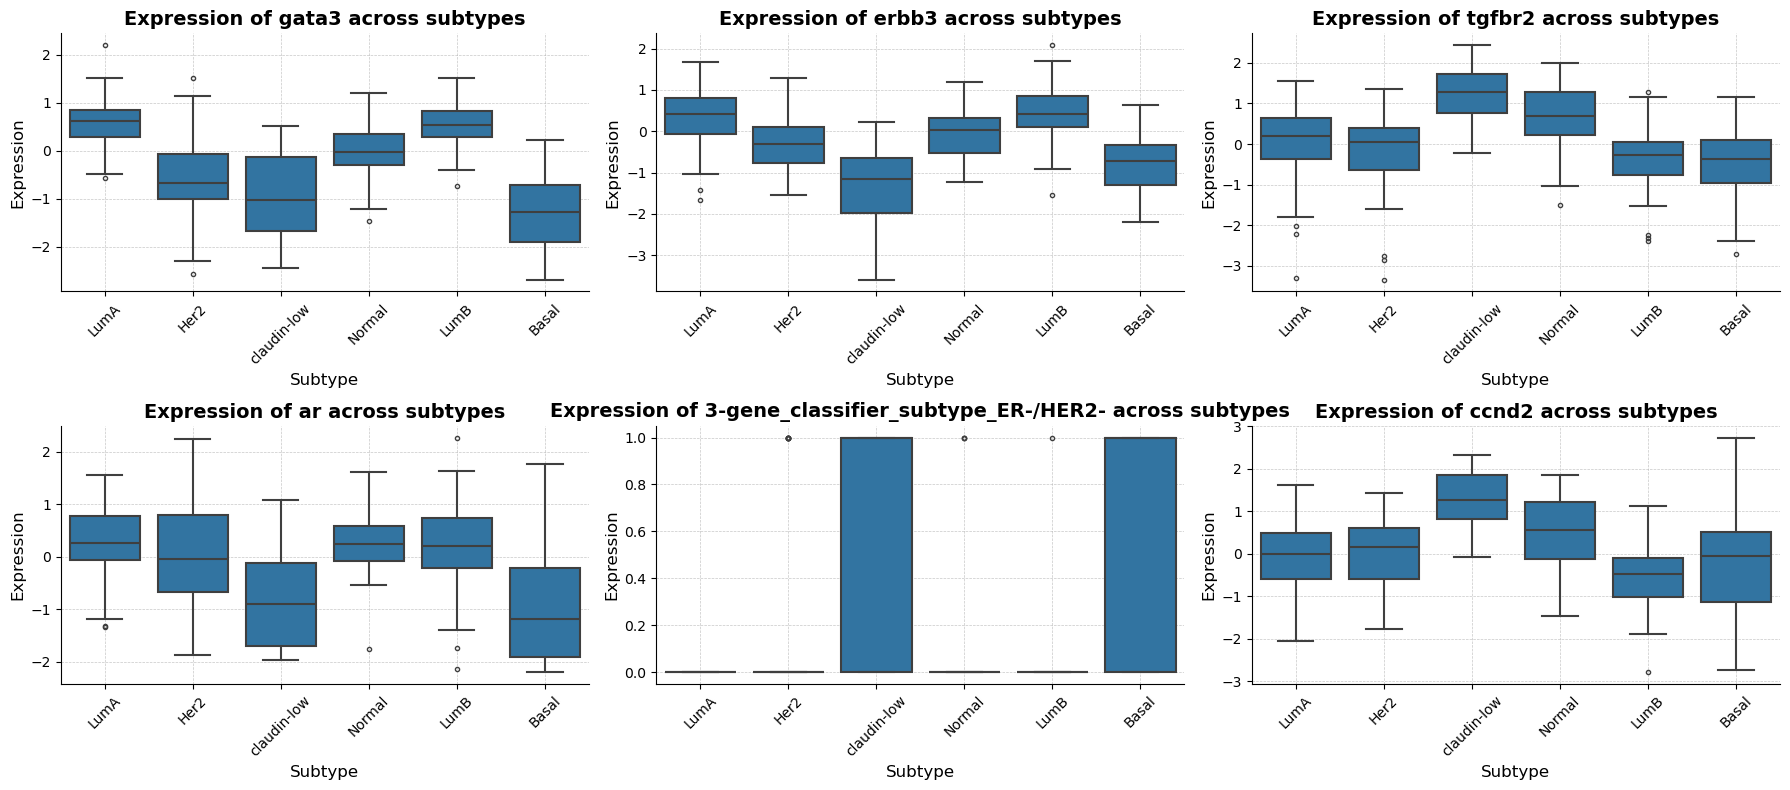


Biological summary for Basal markers:

- **tgfb3**: negative impact in Basal (mean SHAP: -0.00628); highest in Her2, lowest in Basal. Consider literature for biological relevance.
- **lfng**: negative impact in Basal (mean SHAP: -0.00495); highest in Her2, lowest in Basal. Consider literature for biological relevance.
- **3-gene_classifier_subtype_ER-/HER2-**: negative impact in Basal (mean SHAP: -0.00453); highest in LumA, lowest in Basal. Consider literature for biological relevance.
- **gata3**: negative impact in Basal (mean SHAP: -0.00443); highest in LumA, lowest in claudin-low. Consider literature for biological relevance.
- **integrative_cluster_10**: negative impact in Basal (mean SHAP: -0.00433); highest in LumA, lowest in Basal. Consider literature for biological relevance.
- **ccne1**: negative impact in Basal (mean SHAP: -0.00347); highest in LumA, lowest in Her2. Consider literature for biological relevance.

Biological summary for claudin-low markers:

- **gata3**: nega

In [ ]:
# Parameters
N = 6  # top N markers per class

# Get top N marker features per class by absolute mean SHAP value
top_markers_by_class = {}
for cls in mean_shap_df.columns:
    shap_vals = mean_shap_df[cls]
    top_feats = shap_vals.abs().sort_values(ascending=False).head(N).index.tolist()
    top_markers_by_class[cls] = top_feats

print("Top marker features per class (class names):")
for cls, feats in top_markers_by_class.items():
    print(f"{cls}: {feats}")

# Map integer class labels back to class names (if needed)
int_to_class = dict(enumerate(le.classes_))
print("\nClass mapping (int label → class name):", int_to_class)

# Identify Basal-like and Claudin-low class names in your dataset
basal_col = None
claudin_col = None
for name in mean_shap_df.columns:
    if 'Basal' in name or 'basal' in name:
        basal_col = name
    if 'claudin' in name.lower():
        claudin_col = name

print(f"\nClass name for Basal-like: {basal_col}, Claudin-low: {claudin_col}")

# Get top markers for those classes
basal_markers = top_markers_by_class.get(basal_col, [])
claudin_markers = top_markers_by_class.get(claudin_col, [])

print(f"\nTop Basal-like markers ({basal_col}): {basal_markers}")
print(f"Top Claudin-low markers ({claudin_col}): {claudin_markers}")

def marker_shap_table(marker_list, shap_df):
    if not marker_list:
        print("No markers to show.")
        return pd.DataFrame()
    display_df = shap_df.loc[marker_list].T  # transpose to (classes x features)
    display(display_df)
    return display_df

print("\nBasal-like marker feature SHAP values across all classes:")
_ = marker_shap_table(basal_markers, mean_shap_df)

print("\nClaudin-low marker feature SHAP values across all classes:")
_ = marker_shap_table(claudin_markers, mean_shap_df)

# Prepare X_test DataFrame and labels for plotting if needed
X_test_df = pd.DataFrame(X_test, columns=feature_names) if not isinstance(X_test, pd.DataFrame) else X_test
y_test_labels = le.inverse_transform(y_test) if hasattr(le, "inverse_transform") else y_test

def plot_marker_expression(marker_features, X, y, palette=None, n_cols=3):
    if not marker_features:
        print("No marker features to plot.")
        return
    n_rows = int(np.ceil(len(marker_features) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, feature in enumerate(marker_features):
        if feature not in X.columns:
            print(f"Feature {feature} not found in X columns, skipping.")
            continue

        plot_df = pd.DataFrame({feature: X[feature], 'Subtype': y})

        sns.boxplot(
            x='Subtype', y=feature, data=plot_df, ax=axes[i],
            palette=palette, linewidth=1.5, fliersize=3
        )

        axes[i].set_title(f'Expression of {feature} across subtypes', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Subtype', fontsize=12)
        axes[i].set_ylabel('Expression', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='both', labelsize=10)
        sns.despine(ax=axes[i])
        axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Remove unused axes
    for i in range(len(marker_features), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

if basal_markers:
    print(f"\nFeature expression patterns for {basal_col} markers:")
    plot_marker_expression(basal_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker features found for {basal_col}. Skipping plot.")

if claudin_markers:
    print(f"\nFeature expression patterns for {claudin_col} markers:")
    plot_marker_expression(claudin_markers, X_test_df, y_test_labels)
else:
    print(f"\nNo marker features found for {claudin_col}. Skipping plot.")

def marker_report(markers, shap_df, class_name):
    lines = []
    for feature in markers:
        shap_vals = shap_df.loc[feature]
        main_val = shap_vals[class_name]
        highest = shap_vals.idxmax()
        lowest = shap_vals.idxmin()
        direction = "positive impact" if main_val > 0 else "negative impact"
        lines.append(
            f"- **{feature}**: {direction} in {class_name} (mean SHAP: {main_val:.5f}); " +
            f"highest in {highest}, lowest in {lowest}. " +
            f"Consider literature for biological relevance."
        )
    return "\n".join(lines)

if basal_markers:
    print(f"\nBiological summary for {basal_col} markers:\n")
    print(marker_report(basal_markers, mean_shap_df, basal_col))

if claudin_markers:
    print(f"\nBiological summary for {claudin_col} markers:\n")
    print(marker_report(claudin_markers, mean_shap_df, claudin_col))


Link to GBDT and genes notes:

https://docs.google.com/document/d/1qMkQN22xCXzWxgOclj_Ts8lBJWNEQHdpAXT4X0ImvQg/edit?usp=sharing
